In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import os


In [22]:
INIT_LR = 1e-3
EPOCHS = 10
BS = 32

DIRECTORY = r"D:/codes/Face-Mask-Detection-master/dataset_/dataset"
CATEGORIES = ["with_mask", "without_mask"]

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("Loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(labels)
labels = to_categorical(labels)
print(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

Loading images...
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [23]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

(trainX, valX, trainY, valY) = train_test_split(trainX, trainY,
	test_size=0.20, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [24]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = ResNet50(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [25]:
print("Compiling model...")
adam = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=adam,
	metrics=["accuracy"])

# train the head of the network
print("Training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(valX, valY),
	validation_steps=len(valX) // BS,
	epochs=EPOCHS)


Compiling model...
Training head...
Epoch 1/10
25/25 [==============================] - 66s 3s/step - loss: 0.7294 - accuracy: 0.5763 - val_loss: 0.5794 - val_accuracy: 0.7366
Epoch 2/10
25/25 [==============================] - 65s 3s/step - loss: 0.6116 - accuracy: 0.6641 - val_loss: 0.5164 - val_accuracy: 0.7756
Epoch 3/10
25/25 [==============================] - 65s 3s/step - loss: 0.5674 - accuracy: 0.7023 - val_loss: 0.4953 - val_accuracy: 0.7415
Epoch 4/10
25/25 [==============================] - 65s 3s/step - loss: 0.5760 - accuracy: 0.7099 - val_loss: 0.4622 - val_accuracy: 0.7854
Epoch 5/10
25/25 [==============================] - 65s 3s/step - loss: 0.5417 - accuracy: 0.7277 - val_loss: 0.4496 - val_accuracy: 0.7902
Epoch 6/10
25/25 [==============================] - 67s 3s/step - loss: 0.5186 - accuracy: 0.7430 - val_loss: 0.4660 - val_accuracy: 0.7610
Epoch 7/10
25/25 [==============================] - 65s 3s/step - loss: 0.5244 - accuracy: 0.7494 - val_loss: 0.4214 - val_a

In [26]:
# make predictions on the testing set
print("Evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

print("Saving mask detector model...")
model.save("mask_detector_ResNet50.model", save_format="h5")

Evaluating network...
              precision    recall  f1-score   support

   with_mask       0.90      0.74      0.81       129
without_mask       0.78      0.91      0.84       127

    accuracy                           0.83       256
   macro avg       0.84      0.83      0.83       256
weighted avg       0.84      0.83      0.83       256

Saving mask detector model...


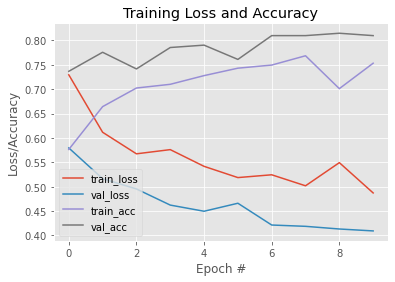

In [27]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(H.history["loss"], label="train_loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.plot(H.history["accuracy"], label="train_acc")
plt.plot(H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot123.png")